In [1]:
# Install required packages
!pip install wordcloud xgboost imbalanced-learn

# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import random
import warnings
warnings.filterwarnings("ignore")

# NLTK imports
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Visualization
from wordcloud import WordCloud

# Preprocessing and balancing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Load the dataset
df = pd.read_csv("Combined Data.csv", index_col=0)

# Create a copy and handle missing values
df1 = df.copy()
df1.dropna(inplace=True)

print("Dataset shape:", df1.shape)
print("\nFirst 5 rows:")
df1.head()


Dataset shape: (52681, 2)

First 5 rows:


,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
# Basic information about the dataset
print("Dataset Info:")
print(df1.info())
print("\n" + "="*50)

# Descriptive statistics for object columns
print("Descriptive statistics for text columns:")
print(df1.describe(include='object').T)
print("\n" + "="*50)

# Add statement length feature
df1['statement_len'] = df1['statement'].apply(lambda x: len(x.split(' ')))
print("Statement length statistics:")
print(df1['statement_len'].describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None

Descriptive statistics for text columns:
           count unique                top   freq
statement  52681  51073  what do you mean?     22
status     52681      7             Normal  16343

Statement length statistics:
count    52681.000000
mean       113.035914
std        163.501877
min          1.000000
25%         15.000000
50%         62.000000
75%        148.000000
max       6300.000000
Name: statement_len, dtype: float64


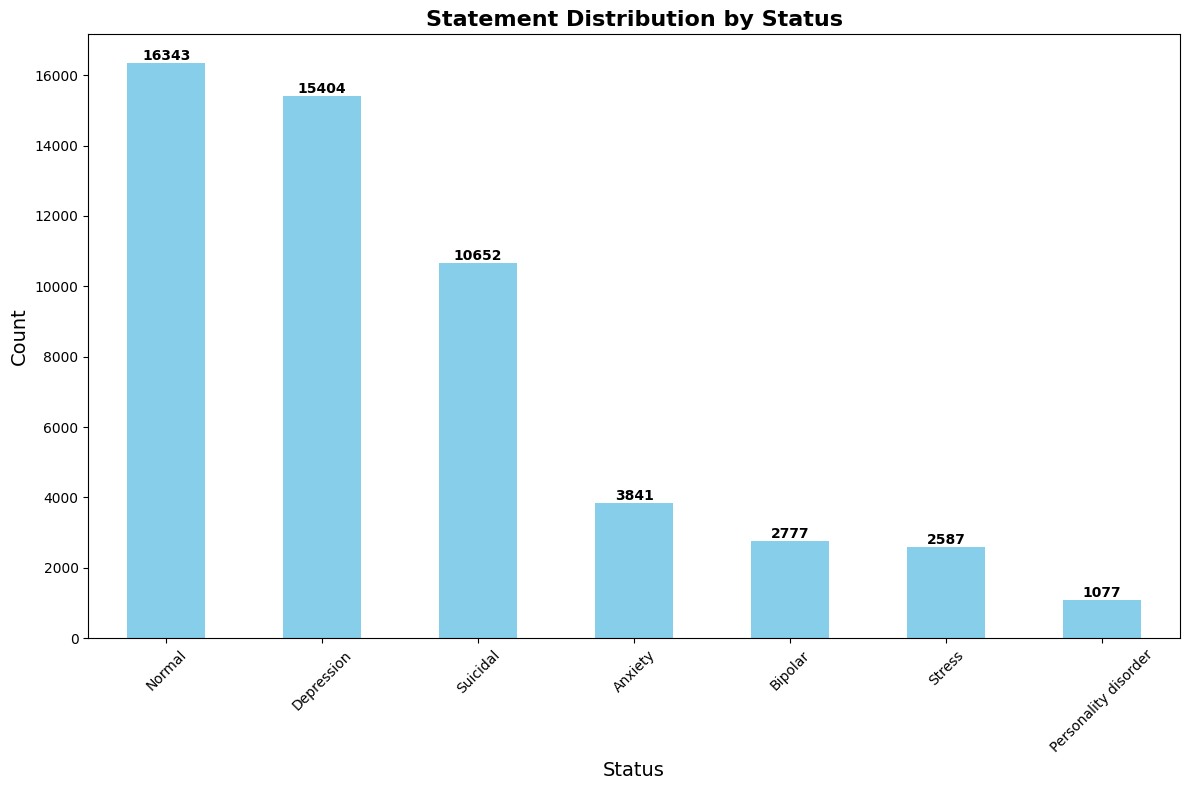

Value counts:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


In [4]:
# Visualize target distribution
plt.figure(figsize=(12, 8))

# Get the unique status values and their counts
status_counts = df1['status'].value_counts()

# Create the bar plot
ax = status_counts.plot(kind='bar', color='skyblue')

# Add count labels on top of each bar
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.title('Statement Distribution by Status', fontsize=16, fontweight='bold')
plt.xlabel('Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Value counts:")
print(status_counts)


In [5]:
# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
more_stopwords = {'u', 'im', 'c'}
stop_words.update(more_stopwords)

def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    # Convert to string and lowercase
    text = str(text).lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'&lt;.*?&gt;', '', text)

    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)

    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)

    # Remove newline characters
    text = re.sub(r'\n', ' ', text)

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

def remove_stopwords(text):
    """Remove stopwords from text"""
    return ' '.join(word for word in text.split() if word not in stop_words)

def stem_text(text):
    """Apply stemming to text"""
    return ' '.join(stemmer.stem(word) for word in text.split())

def preprocess_data(text):
    """Complete preprocessing pipeline"""
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stem_text(text)
    return text


In [7]:
# Create a copy for preprocessing
df2 = df1.copy()

# Apply complete preprocessing
print("Applying preprocessing...")
df2['statement_clean'] = df2['statement'].apply(preprocess_data)

# Encode target variable
l_encoder = LabelEncoder()
df2['status_encoded'] = l_encoder.fit_transform(df2['status'])

# Download punkt_tab resource
import nltk
nltk.download('punkt_tab')

# Tokenize cleaned text
df2['tokens'] = df2['statement_clean'].apply(word_tokenize)

print("Preprocessing completed!")
print("\nSample preprocessed data:")
print(df2[['statement', 'statement_clean', 'status', 'status_encoded']].head())

Applying preprocessing...


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Preprocessing completed!

Sample preprocessed data:
                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                     statement_clean   status  status_encoded  
0                                            oh gosh  Anxiety               0  
1       troubl sleep confus mind restless heart tune  Anxiety               0  
2  wrong back dear forward doubt stay restless re...  Anxiety               0  
3             ive shift focus someth els still worri  Anxiety               0  
4                   restless restless month boy mean  Anxiety               0  


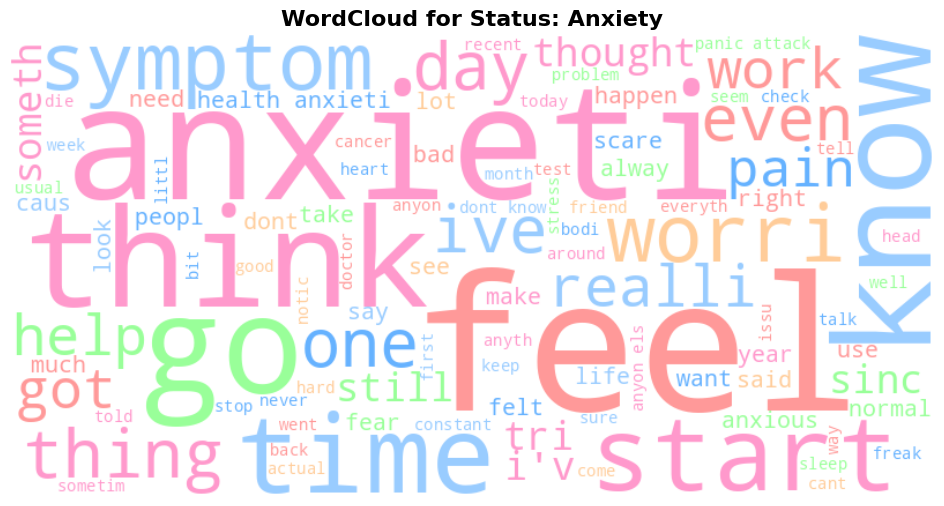

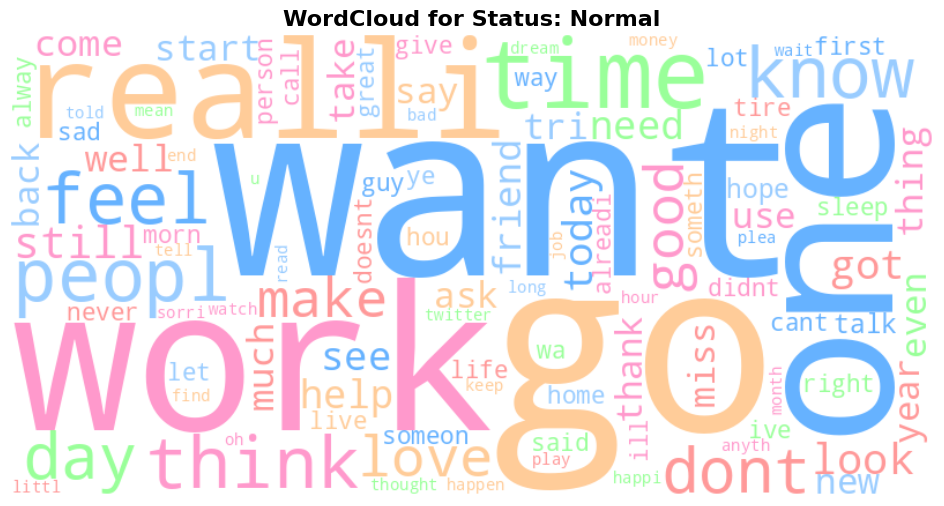

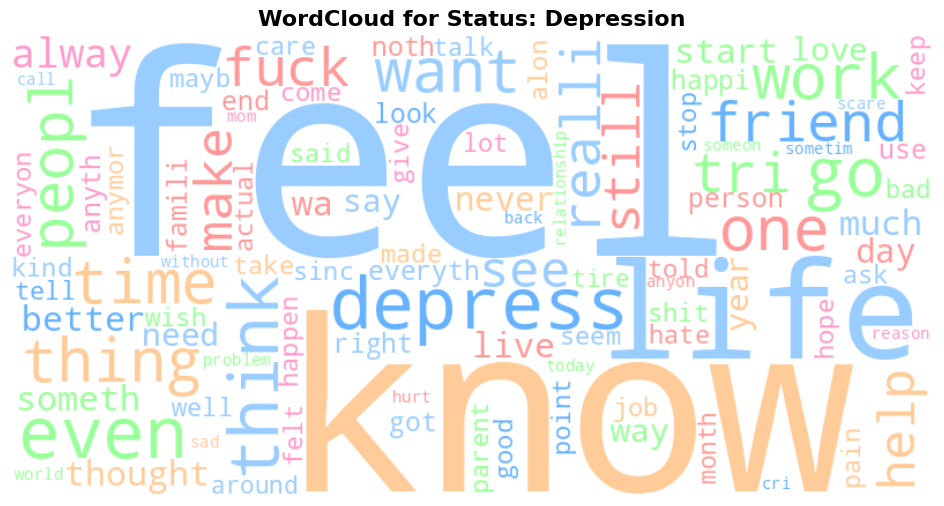

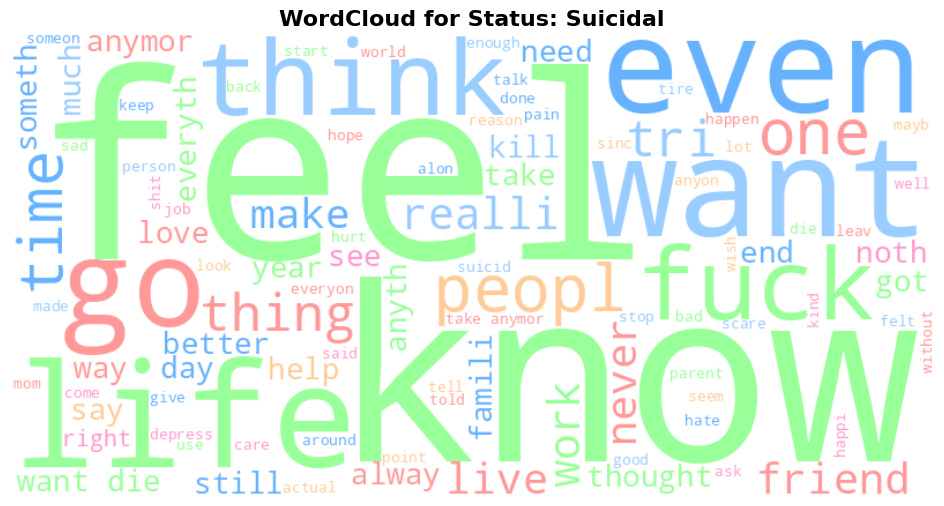

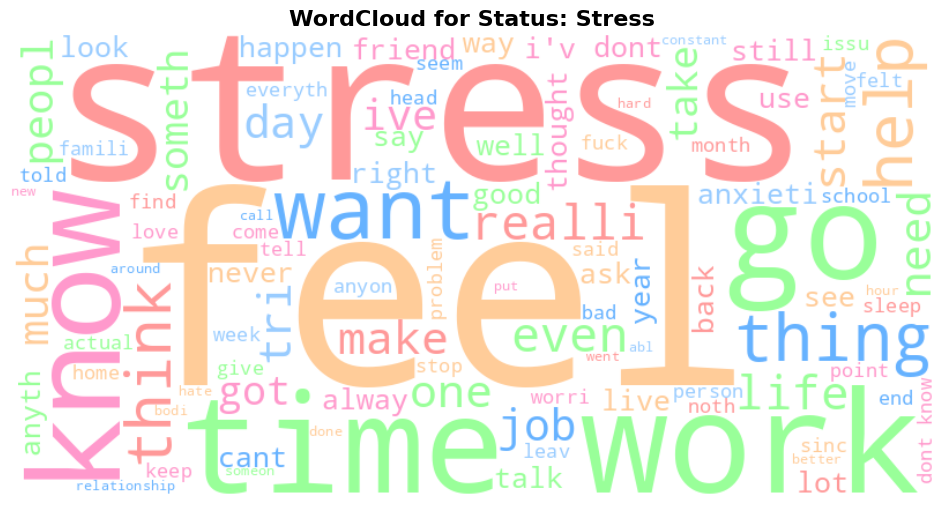

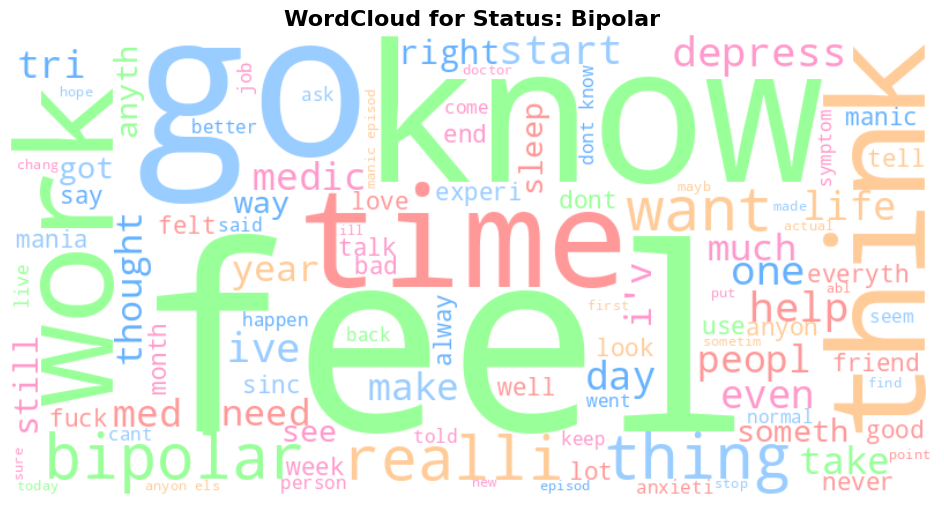

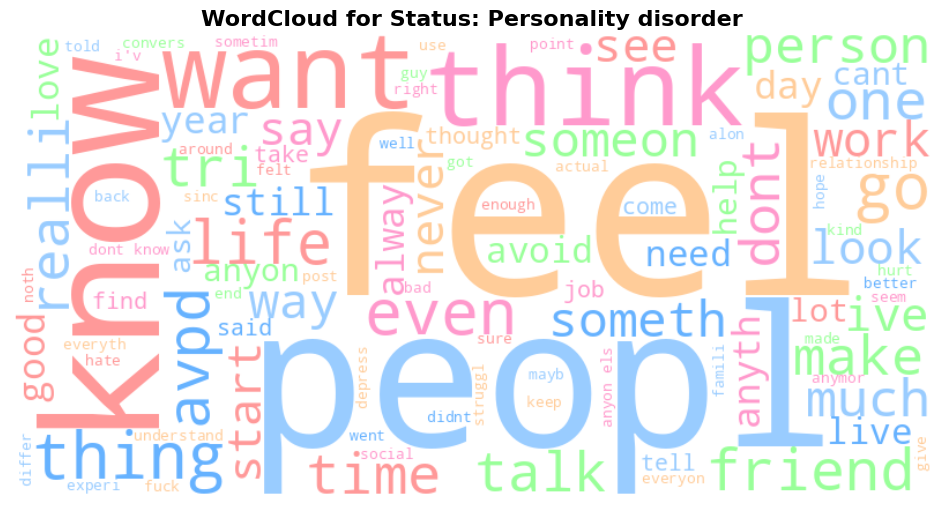

In [8]:
# Generate WordClouds for each status category
statuses = df2['status'].unique()
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF']

def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

for status in statuses:
    # Filter tokens for current status
    tokens_data = ' '.join(
        df2[df2['status'] == status]['statement_clean'].dropna().tolist()
    )

    if tokens_data.strip():  # Check if there's data to visualize
        # Generate WordCloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            color_func=color_func,
            max_words=100
        ).generate(tokens_data)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'WordCloud for Status: {status}', fontsize=16, fontweight='bold')
        plt.show()


In [9]:
# Define features and target
X = df2['statement_clean']
y = df2['status_encoded']

print(f"Total samples: {len(X)}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Create Count Vectorizer
c_vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_df=0.7,
    max_features=10000
)

# Fit and transform
X_train_dtm = c_vectorizer.fit_transform(X_train)
X_test_dtm = c_vectorizer.transform(X_test)

print(f"Feature matrix shape: {X_train_dtm.shape}")


Total samples: 52681
Training samples: 42144
Testing samples: 10537
Feature matrix shape: (42144, 10000)


In [10]:
# Apply random oversampling to handle class imbalance
r_oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = r_oversampler.fit_resample(X_train_dtm, y_train)

print(f"Original training shape: {X_train_dtm.shape}")
print(f"Resampled training shape: {X_train_resampled.shape}")

# Check class distribution after resampling
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(f"Class distribution after resampling: {dict(zip(unique, counts))}")


Original training shape: (42144, 10000)
Resampled training shape: (91518, 10000)
Class distribution after resampling: {np.int64(0): np.int64(13074), np.int64(1): np.int64(13074), np.int64(2): np.int64(13074), np.int64(3): np.int64(13074), np.int64(4): np.int64(13074), np.int64(5): np.int64(13074), np.int64(6): np.int64(13074)}


Training Logistic Regression...
=== LOGISTIC REGRESSION RESULTS ===
Accuracy: 0.7334

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.76      0.75      0.75       768
             Bipolar       0.76      0.75      0.75       556
          Depression       0.70      0.63      0.66      3081
              Normal       0.87      0.93      0.90      3269
Personality disorder       0.56      0.64      0.60       215
              Stress       0.54      0.57      0.55       517
            Suicidal       0.61      0.63      0.62      2131

            accuracy                           0.73     10537
           macro avg       0.69      0.70      0.69     10537
        weighted avg       0.73      0.73      0.73     10537



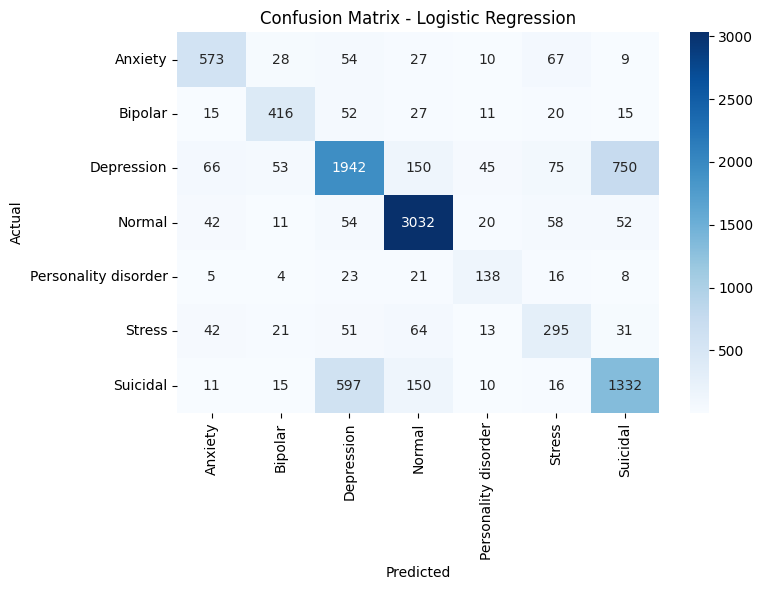

In [11]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_clf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_lr = lr_clf.predict(X_test_dtm)

# Evaluation
labels = l_encoder.classes_
print("=== LOGISTIC REGRESSION RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=labels))

# Confusion Matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()


Training Random Forest...
=== RANDOM FOREST RESULTS ===
Accuracy: 0.7304

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.77      0.75      0.76       768
             Bipolar       0.91      0.69      0.79       556
          Depression       0.66      0.70      0.68      3081
              Normal       0.81      0.93      0.87      3269
Personality disorder       0.88      0.49      0.63       215
              Stress       0.78      0.34      0.48       517
            Suicidal       0.63      0.58      0.61      2131

            accuracy                           0.73     10537
           macro avg       0.78      0.64      0.69     10537
        weighted avg       0.73      0.73      0.72     10537



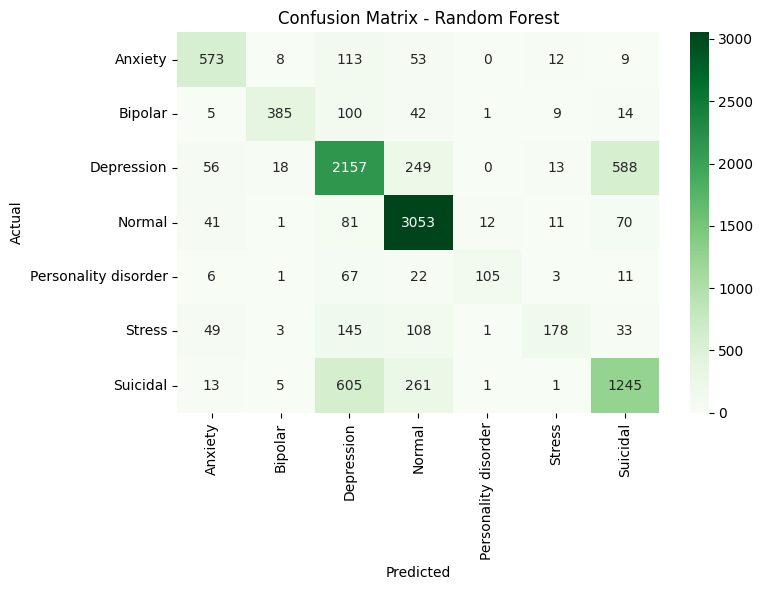

In [12]:
# Train Random Forest
print("Training Random Forest...")
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)
rf_clf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf = rf_clf.predict(X_test_dtm)

# Evaluation
print("=== RANDOM FOREST RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=labels))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()


Training XGBoost...
=== XGBOOST RESULTS ===
Accuracy: 0.7303

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.73      0.77      0.75       768
             Bipolar       0.77      0.78      0.77       556
          Depression       0.78      0.58      0.66      3081
              Normal       0.82      0.92      0.87      3269
Personality disorder       0.46      0.67      0.55       215
              Stress       0.50      0.60      0.54       517
            Suicidal       0.63      0.67      0.65      2131

            accuracy                           0.73     10537
           macro avg       0.67      0.71      0.68     10537
        weighted avg       0.74      0.73      0.73     10537



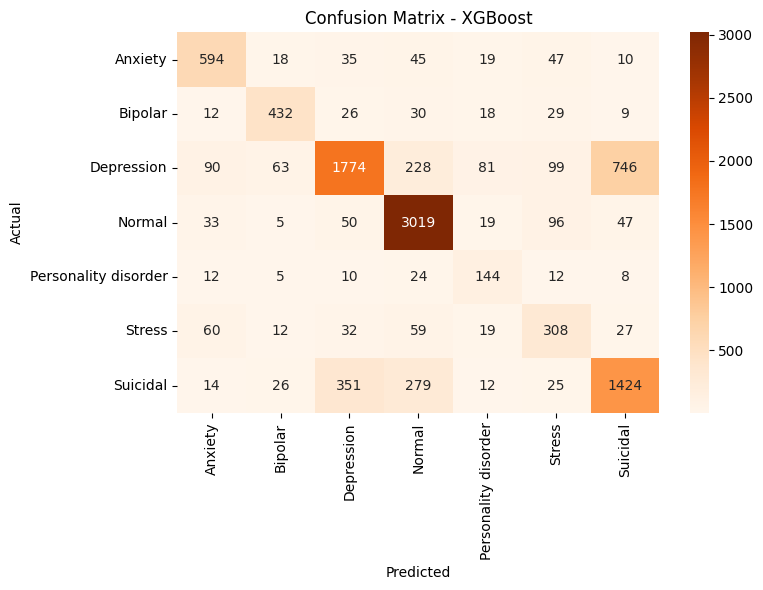

In [13]:
# Train XGBoost
print("Training XGBoost...")
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_xgb = xgb_clf.predict(X_test_dtm)

# Evaluation
print("=== XGBOOST RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=labels))

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()


Training KNN (with feature scaling)...
=== KNN RESULTS ===
Accuracy: 0.3502

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.40      0.17      0.24       768
             Bipolar       0.39      0.08      0.13       556
          Depression       0.37      0.16      0.23      3081
              Normal       0.34      0.83      0.48      3269
Personality disorder       0.47      0.04      0.08       215
              Stress       0.36      0.04      0.08       517
            Suicidal       0.45      0.12      0.19      2131

            accuracy                           0.35     10537
           macro avg       0.40      0.21      0.20     10537
        weighted avg       0.38      0.35      0.28     10537



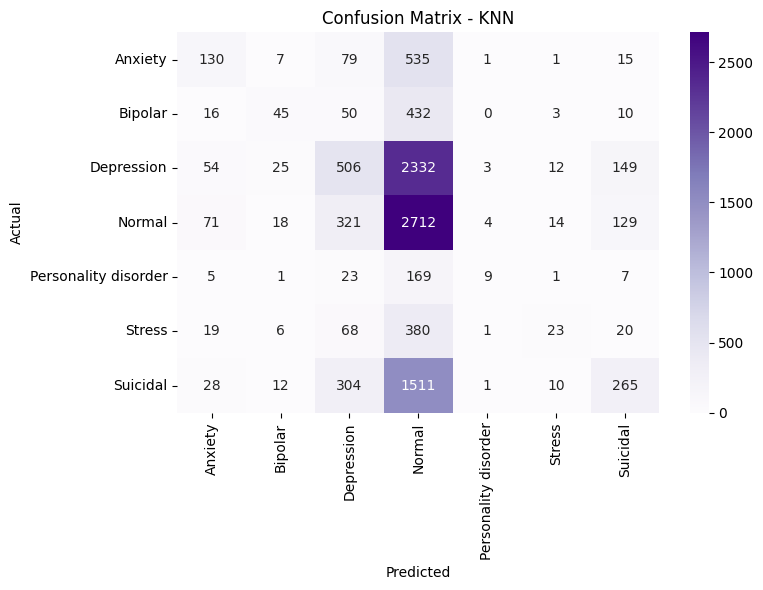

In [14]:
# For KNN, we need to scale the features and use smaller feature set
print("Training KNN (with feature scaling)...")

# Use TF-IDF with limited features for KNN
tfidf_vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Scale features
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

# Train KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_scaled, y_train)

# Predictions
y_pred_knn = knn_clf.predict(X_test_scaled)

# Evaluation
print("=== KNN RESULTS ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=labels))

# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.tight_layout()
plt.show()


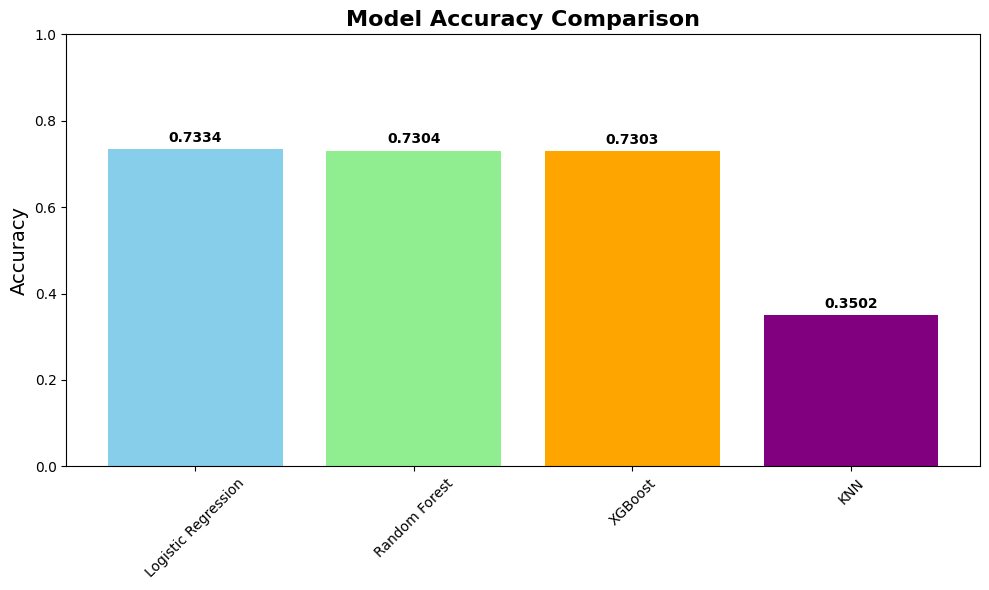

=== FINAL MODEL COMPARISON ===
Logistic Regression: 0.7334
Random Forest: 0.7304
XGBoost: 0.7303
KNN: 0.3502

Best performing model: Logistic Regression with accuracy: 0.7334


In [15]:
# Compare all models
models_results = {
    'Logistic Regression': accuracy_score(y_test, y_pred_lr),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'XGBoost': accuracy_score(y_test, y_pred_xgb),
    'KNN': accuracy_score(y_test, y_pred_knn)
}

# Create comparison visualization
plt.figure(figsize=(10, 6))
models = list(models_results.keys())
accuracies = list(models_results.values())

bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'orange', 'purple'])
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)

# Add accuracy labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("=== FINAL MODEL COMPARISON ===")
for model, accuracy in models_results.items():
    print(f"{model}: {accuracy:.4f}")

best_model = max(models_results, key=models_results.get)
print(f"\nBest performing model: {best_model} with accuracy: {models_results[best_model]:.4f}")
